In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

from src.ad_hmm import sku_predict
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 2

### RMSE analysis for HMM

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

(846632, 15)


In [5]:
#clean train/test
train = train_test[(train_test.validation==False) & (train_test.validation_clean==True)]
validation = train_test[(train_test.validation==True) & (train_test.validation_clean==True)]
train.shape,validation.shape

((797490, 15), (3815, 15))

### y_actual

In [6]:
y_act = validation[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"]].rename(columns = {"DAILY_UNITS":"actual"})
y_act.head()

,Encoded_SKU_ID,SALES_DATE,actual
100,96,2022-07-27,2
218,187,2022-07-29,0
420,297,2022-07-29,6
652,372,2022-07-27,1
831,412,2022-07-26,4


### y_pred null

In [7]:
y_pred_null = pd.read_csv("../../data/null_prediction_validation_result_v0.csv").drop(columns = "Unnamed: 0")
y_pred_null["SALES_DATE"] = pd.to_datetime(y_pred_null["SALES_DATE"])
y_pred_null.head()

,Encoded_SKU_ID,SALES_DATE,predicted
0,1,2022-07-25,1
1,1,2022-07-26,1
2,1,2022-07-27,1
3,1,2022-07-28,1
4,1,2022-07-29,1


In [8]:
rmse(y_act,y_pred_null)

6.59603916258372

### y_pred HMM

In [9]:
hmm_output = pd.read_csv("../../data/hmm_result_v0.csv",index_col=0)
hmm_output.head()

,predicted,predicted_30,predicted_45,predicted_60,predicted_max,Encoded_SKU_ID
2022-07-25,1.0,0.0,0.5,1.0,1.0,7
2022-07-26,1.0,0.5,1.0,1.5,0.5,7
2022-07-27,1.0,0.5,0.5,1.5,0.5,7
2022-07-28,0.0,0.5,2.0,1.5,1.0,7
2022-07-29,2.0,0.5,0.0,0.5,1.0,7


In [10]:
hmm_output.index = pd.to_datetime(hmm_output.index)

In [11]:
SKUs_hmm = hmm_output["Encoded_SKU_ID"].unique()
y_pred_null_subset = y_pred_null[y_pred_null.Encoded_SKU_ID.isin(SKUs_hmm)]

In [12]:
rmse(y_act,y_pred_null_subset)

1.2758050679584916

In [13]:
for col in hmm_output.columns:
    if "pred" in col:
        y_pred_hmm = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",col\
                                                                  ]].rename(columns={col:"predicted"})
        print (f"For {col}, rmse(hmm) = {rmse(y_act,y_pred_hmm):.4f}")

For predicted, rmse(hmm) = 1.3527
For predicted_30, rmse(hmm) = 1.3724
For predicted_45, rmse(hmm) = 1.2986
For predicted_60, rmse(hmm) = 1.3315
For predicted_max, rmse(hmm) = 1.2358


In [14]:
(1.2758 - 1.2358)*100/1.2758

3.13528766264305

### RMSE SKU level

In [15]:
rmse_sku_null = rmse_sku(y_act,y_pred_null)
rmse_sku_hmm = rmse_sku(y_act,y_pred_hmm)

In [16]:
rmse_sku_hmm.to_excel("../../results/sku_level_hmm_rmse.xlsx")

In [17]:
rmse_joined = rmse_sku_null.merge(rmse_sku_hmm, left_index = True, right_index = True,\
                                suffixes = ("_null","_hmm"))

In [18]:
rmse_joined.head()

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm
Encoded_SKU_ID,,,,,,
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873
380,3.316625,0.714286,4.643275,0.866025,0.714286,1.212436
73,3.139609,1.571429,1.997933,3.070598,1.571429,1.954017
526,2.777460,3.000000,0.925820,3.223795,3.000000,1.074598
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020


In [19]:
((rmse_joined["mean_du_null"] == rmse_joined["mean_du_hmm"])==False).sum()

0

In [20]:
(rmse_joined["rmse_du_hmm"] < rmse_joined["rmse_du_null"]).mean()

0.44375

In [21]:
(rmse_joined["rmse_du_hmm"] <= rmse_joined["rmse_du_null"]).mean()

0.53125

In [22]:
rmse_joined["delta_rmse"] = rmse_joined["rmse_du_null"] - rmse_joined["rmse_du_hmm"]
rmse_joined.sort_values(by="delta_rmse", ascending = False)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
380,3.316625,0.714286,4.643275,0.866025,0.714286,1.212436,2.450599
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020,2.329046
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873,2.052873
245,2.329929,0.714286,3.261901,0.534522,0.714286,0.748331,1.795407
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
...,...,...,...,...,...,...,...
519,0.654654,0.428571,1.527525,2.000000,0.428571,4.666667,-1.345346
27,0.534522,0.285714,1.870829,1.927248,0.285714,6.745369,-1.392726
465,1.511858,2.857143,0.529150,3.023716,2.857143,1.058301,-1.511858


In [23]:
rmse_joined.loc[rmse_joined["delta_rmse"]>0.0]["mean_du_null"].mean()

0.7686116700201207

In [24]:
rmse_joined.loc[rmse_joined["delta_rmse"]==0.0]["mean_du_null"].mean()

0.5

In [25]:
rmse_joined.loc[rmse_joined["delta_rmse"]<0.0]["mean_du_null"].mean()

0.8400000000000001

In [26]:
rmse_joined.sort_values(by="delta_rmse", ascending = True)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
447,1.463850,2.000000,0.731925,3.712912,2.000000,1.856456,-2.249062
30,0.845154,1.142857,0.739510,2.679286,1.142857,2.344375,-1.834131
465,1.511858,2.857143,0.529150,3.023716,2.857143,1.058301,-1.511858
27,0.534522,0.285714,1.870829,1.927248,0.285714,6.745369,-1.392726
519,0.654654,0.428571,1.527525,2.000000,0.428571,4.666667,-1.345346
...,...,...,...,...,...,...,...
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
245,2.329929,0.714286,3.261901,0.534522,0.714286,0.748331,1.795407
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873,2.052873


### Plot some preds

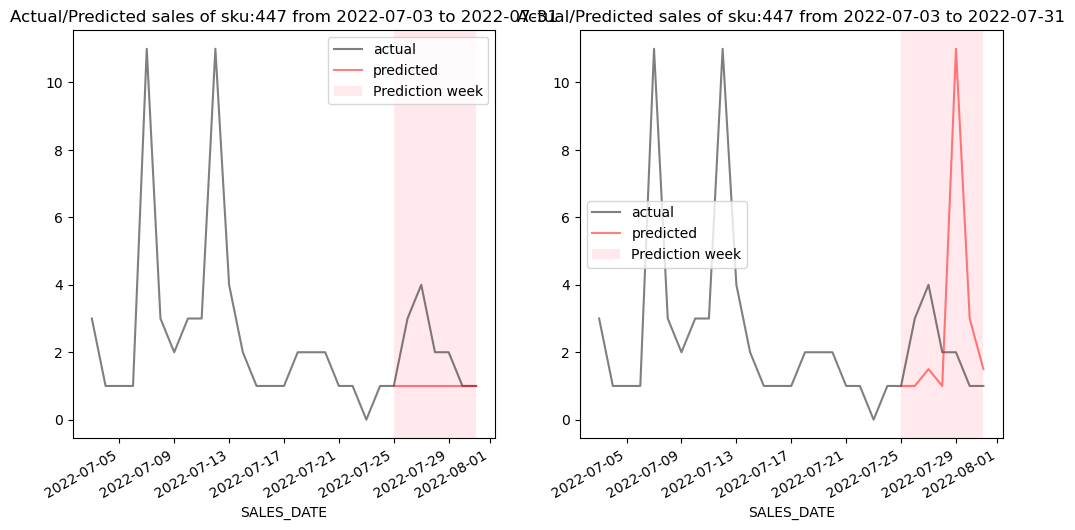

In [27]:
sku_id = 447
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

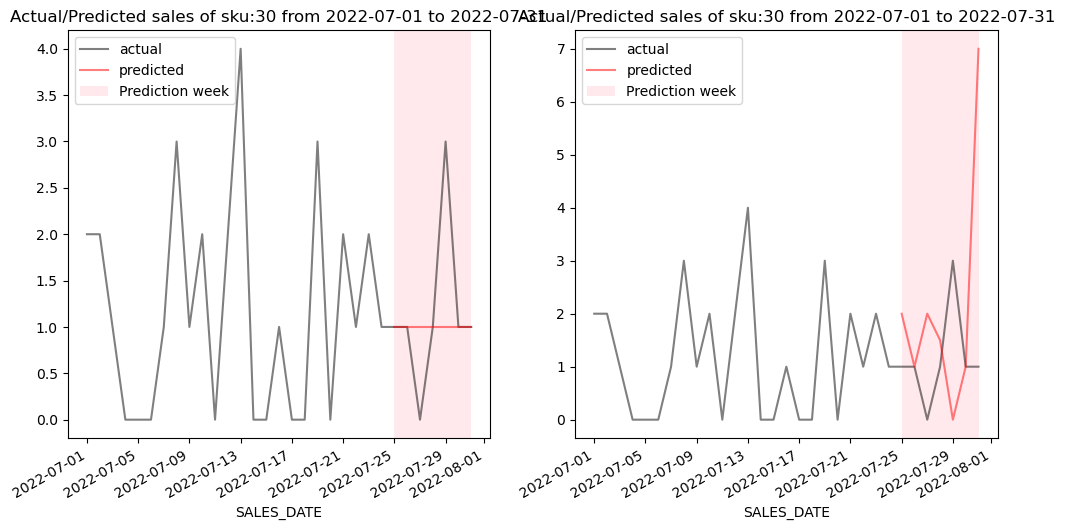

In [28]:
sku_id = 30
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

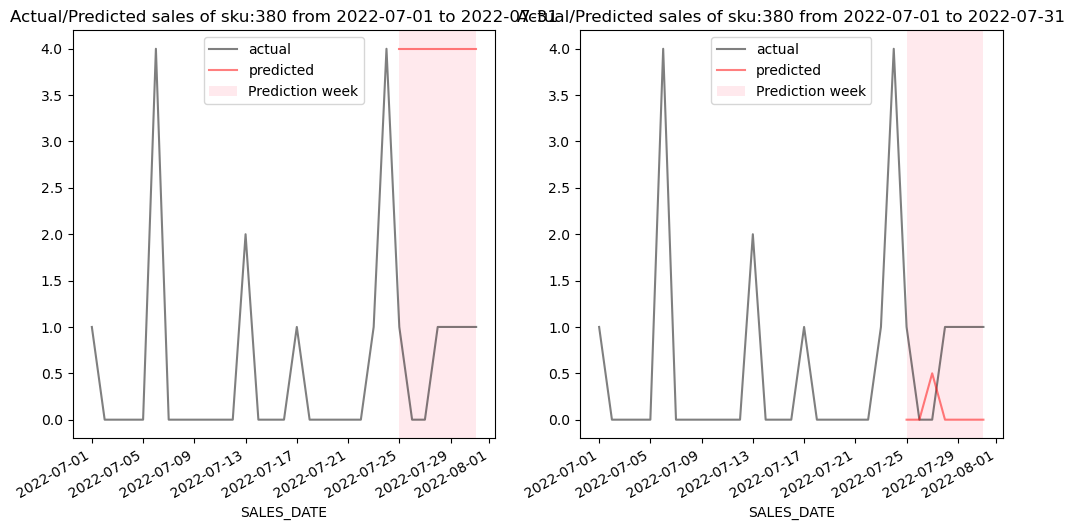

In [29]:
sku_id = 380
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

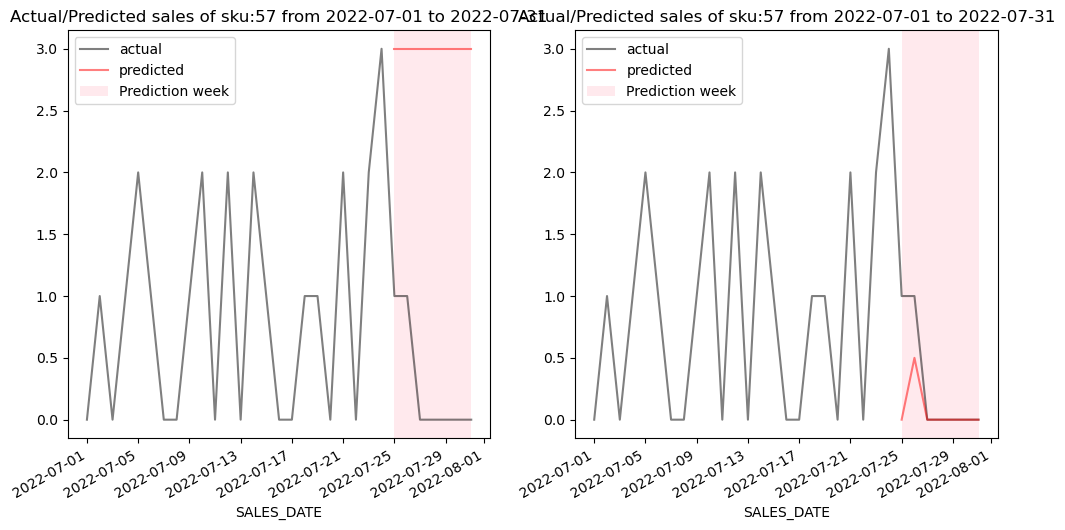

In [30]:
sku_id = 57
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

### Pick best prediction column for each SKU

In [31]:
rmse_sku_hmm_dates = pd.DataFrame()
for i,col in enumerate(hmm_output.columns):
    if "pred" in col:
        y_pred_hmm = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",col\
                                                                  ]].rename(columns={col:"predicted"})
        rmse_sku_hmm_i = rmse_sku(y_act,y_pred_hmm)
        if i ==0:
            rmse_sku_hmm_dates = rmse_sku_hmm_i
        else:
            rmse_sku_hmm_dates = rmse_sku_hmm_dates.merge(rmse_sku_hmm_i, left_index = True, right_index = True,\
                                suffixes = ("",f"_{col.split('_')[-1]}"))

In [32]:
rmse_sku_hmm_dates.head()

,rmse_du,mean_du,pct_rmse,rmse_du_30,mean_du_30,pct_rmse_30,rmse_du_45,mean_du_45,pct_rmse_45,rmse_du_60,mean_du_60,pct_rmse_60,rmse_du_max,mean_du_max,pct_rmse_max
Encoded_SKU_ID,,,,,,,,,,,,,,,
447,5.147815,2.000000,2.573908,1.463850,2.000000,0.731925,1.309307,2.000000,0.654654,1.362770,2.000000,0.681385,3.712912,2.000000,1.856456
73,3.070598,1.571429,1.954017,3.515273,1.571429,2.236992,3.167920,1.571429,2.015949,3.817254,1.571429,2.429162,3.070598,1.571429,1.954017
53,2.853569,2.285714,1.248437,2.464027,2.285714,1.078012,3.076408,2.285714,1.345928,2.375470,2.285714,1.039268,2.070197,2.285714,0.905711
465,2.738613,2.857143,0.958514,3.023716,2.857143,1.058301,3.173551,2.857143,1.110743,2.382975,2.857143,0.834041,3.023716,2.857143,1.058301
543,2.535463,0.571429,4.437060,1.772811,0.571429,3.102418,2.052873,0.571429,3.592527,1.118034,0.571429,1.956559,1.133893,0.571429,1.984313


In [33]:
rmse_cols = [col for col in rmse_sku_hmm_dates.columns if "rmse_du" in col]
rmse_cols

['rmse_du', 'rmse_du_30', 'rmse_du_45', 'rmse_du_60', 'rmse_du_max']

In [34]:
rmse_sku_hmm_dates["min_rmse"] = rmse_sku_hmm_dates[rmse_cols].min()

rmse_sku_hmm_dates["argmin_period"] = np.argmin(rmse_sku_hmm_dates[rmse_cols].values,axis=1)

In [35]:
rmse_sku_hmm_dates["min_period"] = rmse_sku_hmm_dates["argmin_period"].apply(lambda x: rmse_cols[x])

#### Get prediction basis best rmse

In [36]:
rmse_sku_hmm_dates.head()

,rmse_du,mean_du,pct_rmse,rmse_du_30,mean_du_30,pct_rmse_30,rmse_du_45,mean_du_45,pct_rmse_45,rmse_du_60,mean_du_60,pct_rmse_60,rmse_du_max,mean_du_max,pct_rmse_max,min_rmse,argmin_period,min_period
Encoded_SKU_ID,,,,,,,,,,,,,,,,,,
447,5.147815,2.000000,2.573908,1.463850,2.000000,0.731925,1.309307,2.000000,0.654654,1.362770,2.000000,0.681385,3.712912,2.000000,1.856456,NaN,2,rmse_du_45
73,3.070598,1.571429,1.954017,3.515273,1.571429,2.236992,3.167920,1.571429,2.015949,3.817254,1.571429,2.429162,3.070598,1.571429,1.954017,NaN,0,rmse_du
53,2.853569,2.285714,1.248437,2.464027,2.285714,1.078012,3.076408,2.285714,1.345928,2.375470,2.285714,1.039268,2.070197,2.285714,0.905711,NaN,4,rmse_du_max
465,2.738613,2.857143,0.958514,3.023716,2.857143,1.058301,3.173551,2.857143,1.110743,2.382975,2.857143,0.834041,3.023716,2.857143,1.058301,NaN,3,rmse_du_60
543,2.535463,0.571429,4.437060,1.772811,0.571429,3.102418,2.052873,0.571429,3.592527,1.118034,0.571429,1.956559,1.133893,0.571429,1.984313,NaN,3,rmse_du_60


In [37]:
period_col_map= {
    "rmse_du":"predicted", "rmse_du_30":"predicted_30", "rmse_du_45":"predicted_45",\
    "rmse_du_60":"predicted_60", "rmse_du_max":"predicted_max"
}

In [38]:
y_pred_hmm_best = pd.DataFrame()
cnt = 0
for sku_id,best_period in zip(rmse_sku_hmm_dates.index,rmse_sku_hmm_dates["min_period"]):
    best_col = period_col_map[best_period]
    mask_sku = hmm_output.Encoded_SKU_ID==sku_id
    y_pred_hmm_sku = hmm_output.loc[mask_sku].reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]].rename(columns={best_col:"predicted"})
    y_pred_hmm_best = pd.concat([y_pred_hmm_best,y_pred_hmm_sku])

In [39]:
y_pred_hmm_best.shape,y_pred_hmm.shape

((1120, 3), (1120, 3))

In [40]:
y_pred_hmm_max = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE","predicted_max"\
                                                                  ]].rename(columns={"predicted_max":"predicted"})

In [61]:
y_pred_hmm_best1 = y_pred_hmm_best.copy()
y_pred_hmm_best1["predicted"] = y_pred_hmm_best1["predicted"].round(0)
y_pred_hmm_best1

y_pred_hmm_best2 = y_pred_hmm_best.copy()
y_pred_hmm_best2["predicted"] = y_pred_hmm_best2["predicted"].apply(np.floor)
y_pred_hmm_best2

y_pred_hmm_best3 = y_pred_hmm_best.copy()
y_pred_hmm_best3["predicted"] = y_pred_hmm_best3["predicted"].apply(np.ceil)
y_pred_hmm_best3

,Encoded_SKU_ID,SALES_DATE,predicted
0,447,2022-07-25,1.0
1,447,2022-07-26,1.0
2,447,2022-07-27,2.0
3,447,2022-07-28,2.0
4,447,2022-07-29,1.0
...,...,...,...
2,289,2022-07-27,0.0
3,289,2022-07-28,0.0
4,289,2022-07-29,0.0
5,289,2022-07-30,1.0


In [62]:
rmse(y_act,y_pred_null_subset),rmse(y_act,y_pred_hmm_max),\
rmse(y_act,y_pred_hmm_best),rmse(y_act,y_pred_hmm_best1),rmse(y_act,y_pred_hmm_best2),rmse(y_act,y_pred_hmm_best3)

(1.2758050679584916,
 1.2358123412788622,
 0.9571162043197412,
 1.0,
 0.9874208829065749,
 0.9755950565094691)

In [43]:
(1.2758050679584916-0.957116204319741)/1.2758050679584916

0.24979432331986878

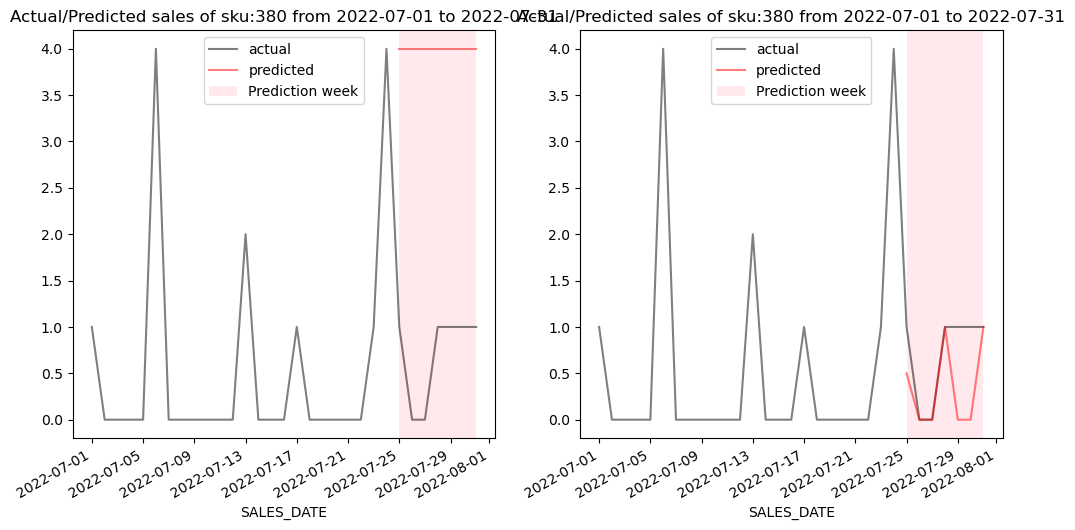

In [44]:
sku_id = 380
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])

In [45]:
y_pred_hmm_best["Encoded_SKU_ID"].unique()

array([447,  73,  53, 465, 543, 404, 306, 146, 118, 320, 505, 313, 467,
       526, 437, 137, 119, 409, 544, 512, 148, 521, 410, 171, 337, 444,
       247, 551, 281, 554,  33, 574,  62, 352, 334, 426,  88, 292, 161,
       402, 205,  96, 513, 316, 498, 522, 123,  30, 298, 528, 167, 225,
        71, 361, 310, 452, 366, 378, 573,  57, 280, 188, 277,  12, 495,
       203,  78, 395, 314, 575,  32, 363, 553, 516, 439, 440, 150,  65,
       374,  75, 323,   7, 340, 386, 318, 120, 550, 264, 166, 191, 397,
       373, 266,  64, 302, 245, 100, 419,  63, 523,  92, 114, 446, 209,
       362,  21, 189, 536, 483, 529, 473, 272, 322, 177, 477, 407, 349,
       224, 204, 262, 423, 471, 422, 393, 519, 539, 127, 180, 234, 408,
       445,  81, 173, 228, 370, 460, 284, 187, 210, 215,  15, 380, 542,
        27, 175, 524, 223, 369, 130, 132, 163,  83,  17, 533, 258,  51,
       389, 308, 368, 289])

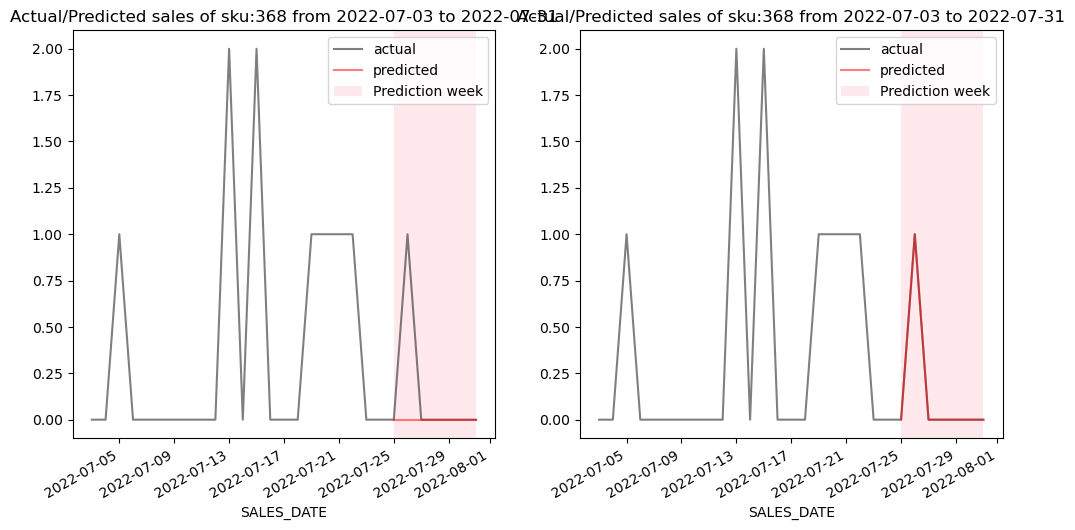

In [46]:
sku_id = 368
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])

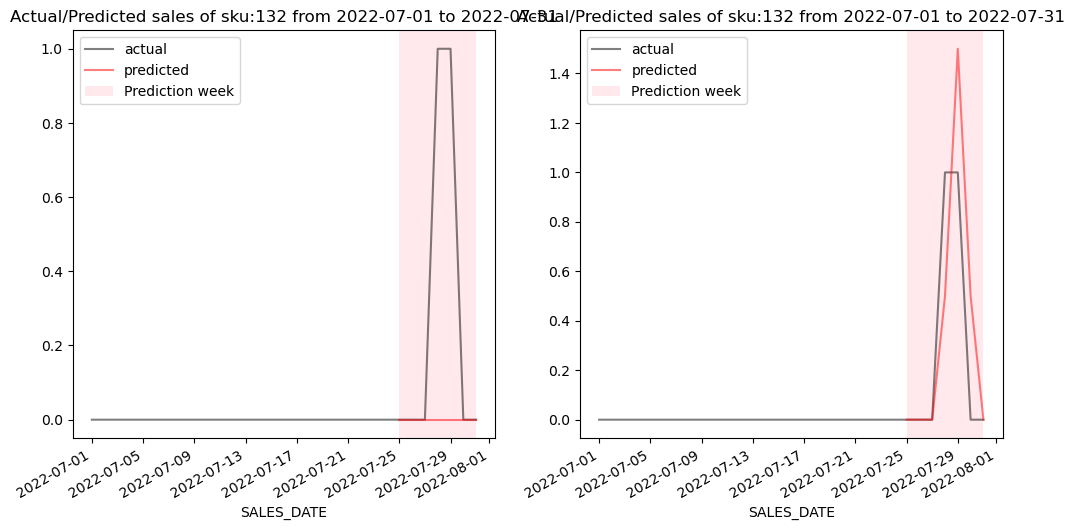

In [47]:
sku_id = 132
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])

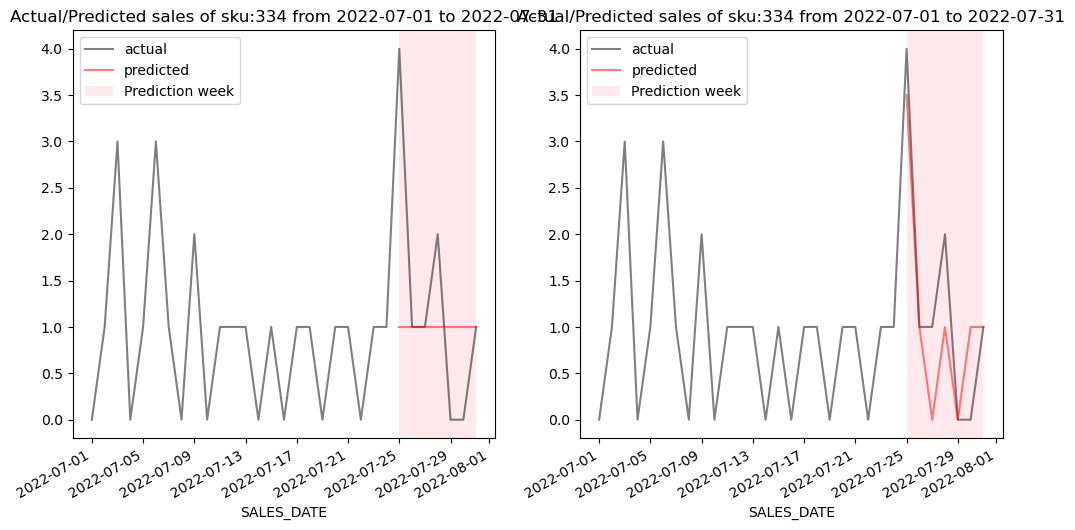

In [48]:
sku_id = 334
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])

### Bad performance SKUs

In [49]:
rmse_sku_null = rmse_sku(y_act,y_pred_null)
rmse_sku_hmm_best = rmse_sku(y_act,y_pred_hmm_best)
rmse_sku_hmm_best.to_excel("../../results/sku_level_hmm_rmse.xlsx")

In [50]:
rmse_joined_best = rmse_sku_null.merge(rmse_sku_hmm_best, left_index = True, right_index = True,\
                                suffixes = ("_null","_hmm"))

In [51]:
rmse_joined_best["delta_rmse"] = rmse_joined_best["rmse_du_null"] - rmse_joined_best["rmse_du_hmm"]
rmse_joined_best.sort_values(by="delta_rmse", ascending = False)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
306,4.105745,1.000000,4.105745,1.133893,1.000000,1.133893,2.971852
380,3.316625,0.714286,4.643275,0.566947,0.714286,0.793725,2.749678
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020,2.329046
245,2.329929,0.714286,3.261901,0.462910,0.714286,0.648074,1.867019
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
...,...,...,...,...,...,...,...
473,0.534522,0.285714,1.870829,0.845154,0.285714,2.958040,-0.310632
30,0.845154,1.142857,0.739510,1.164965,1.142857,1.019344,-0.319810
467,0.534522,0.285714,1.870829,0.963624,0.285714,3.372684,-0.429102


In [52]:
rmse_joined_best.sort_values(by="delta_rmse", ascending = True)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
465,1.511858,2.857143,0.529150,2.382975,2.857143,0.834041,-0.871117
544,0.755929,1.000000,0.755929,1.195229,1.000000,1.195229,-0.439300
467,0.534522,0.285714,1.870829,0.963624,0.285714,3.372684,-0.429102
30,0.845154,1.142857,0.739510,1.164965,1.142857,1.019344,-0.319810
473,0.534522,0.285714,1.870829,0.845154,0.285714,2.958040,-0.310632
...,...,...,...,...,...,...,...
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
245,2.329929,0.714286,3.261901,0.462910,0.714286,0.648074,1.867019
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020,2.329046


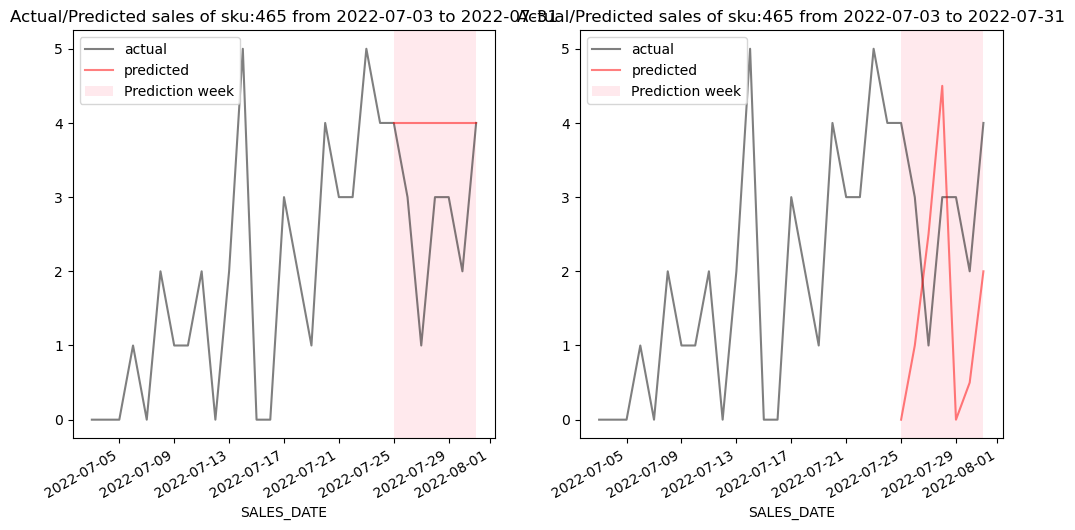

In [53]:
sku_id = 465
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])

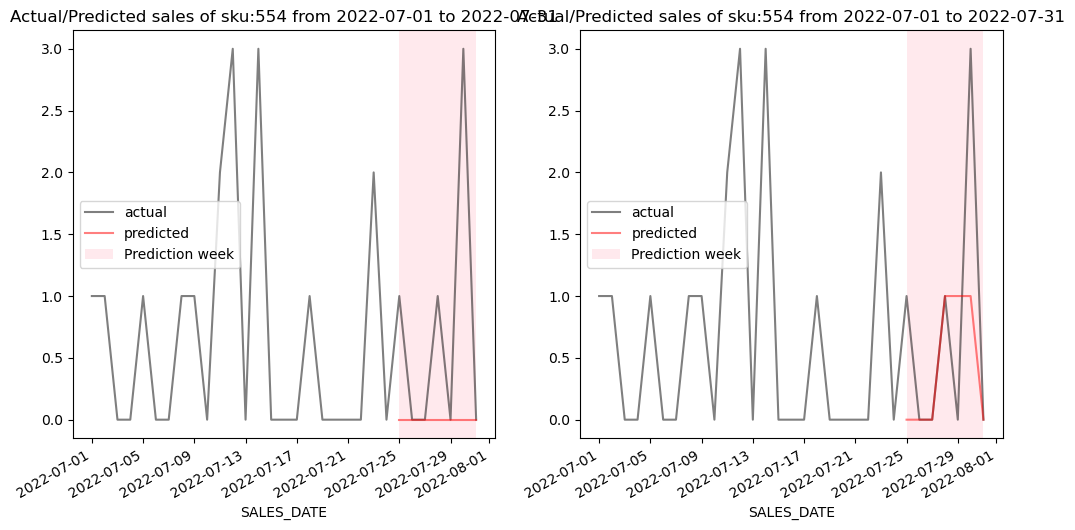

In [54]:
sku_id = 554
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm_best, sku_id, ax1 = ax[1])